In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

In [23]:
# 1. Load Data

fg = pd.read_csv("fear_greed_index.csv")

fg.columns = [c.strip().lower().replace(" ", "_") for c in fg.columns]

if "date" in fg.columns:
    fg["date"] = pd.to_datetime(fg["date"], errors="coerce")
elif "timestamp" in fg.columns:
    fg["date"] = pd.to_datetime(fg["timestamp"], unit="s", errors="coerce")
else:
    for c in fg.columns:
        if fg[c].astype(str).str.contains(r"-\d{2}-", regex=True).any():  # fixed regex warning
            fg["date"] = pd.to_datetime(fg[c], errors="coerce")
            break

if "value" in fg.columns:
    fg["sentiment_value"] = pd.to_numeric(fg["value"], errors="coerce")
if "classification" in fg.columns:
    fg["sentiment_class"] = fg["classification"].astype(str).str.title()

fg = fg[["date", "sentiment_value", "sentiment_class"]].dropna(subset=["date"]).sort_values("date")

print("Fear & Greed rows:", len(fg))
print(fg.head())


Fear & Greed rows: 2644
        date  sentiment_value sentiment_class
0 2018-02-01               30            Fear
1 2018-02-02               15    Extreme Fear
2 2018-02-03               40            Fear
3 2018-02-04               24    Extreme Fear
4 2018-02-05               11    Extreme Fear


In [24]:
# 2. EDA & Derived Features
fg = fg.sort_values("date")

# Rolling averages and volatility
fg["roll_7d_mean"] = fg["sentiment_value"].rolling(7, min_periods=3).mean()
fg["roll_30d_mean"] = fg["sentiment_value"].rolling(30, min_periods=7).mean()
fg["roll_7d_std"] = fg["sentiment_value"].rolling(7, min_periods=3).std()

# Weekly Aggregation
fg_weekly = (
    fg.assign(week=fg["date"].dt.to_period("W").apply(lambda p: p.start_time))
      .groupby("week", as_index=False)
      .agg(mean=("sentiment_value", "mean"),
           median=("sentiment_value", "median"),
           min=("sentiment_value", "min"),
           max=("sentiment_value", "max"))
)

print("\nWeekly Aggregated Data:")
print(fg_weekly.head())

# Sentiment class counts
regime_counts = (
    fg["sentiment_class"]
    .value_counts()
    .rename_axis("sentiment_class")
    .reset_index(name="count")
)

print("\nSentiment Class Counts:")
print(regime_counts)


Weekly Aggregated Data:
        week       mean  median  min  max
0 2018-01-29  27.250000    27.0   15   40
1 2018-02-05  30.571429    31.0    8   54
2 2018-02-12  58.142857    63.0   35   74
3 2018-02-19  48.857143    44.0   31   74
4 2018-02-26  43.857143    44.0   37   56

Sentiment Class Counts:
  sentiment_class  count
0            Fear    781
1           Greed    633
2    Extreme Fear    508
3         Neutral    396
4   Extreme Greed    326


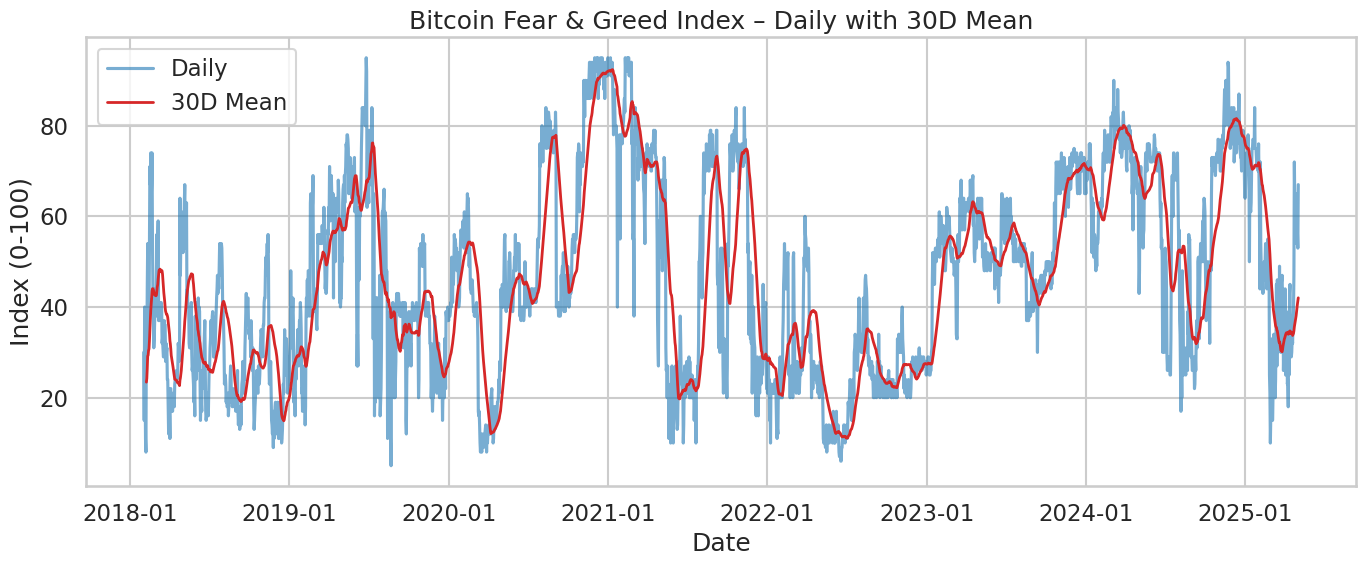

/tmp/ipython-input-3424854639.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=regime_counts, x="sentiment_class", y="count", ax=ax, palette="viridis")


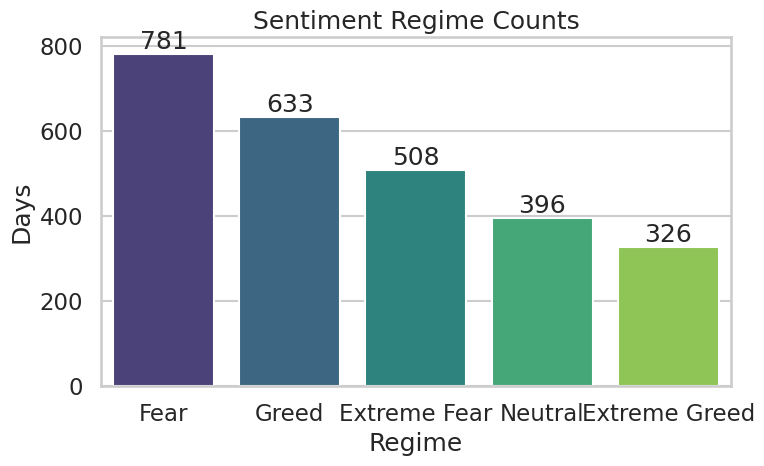

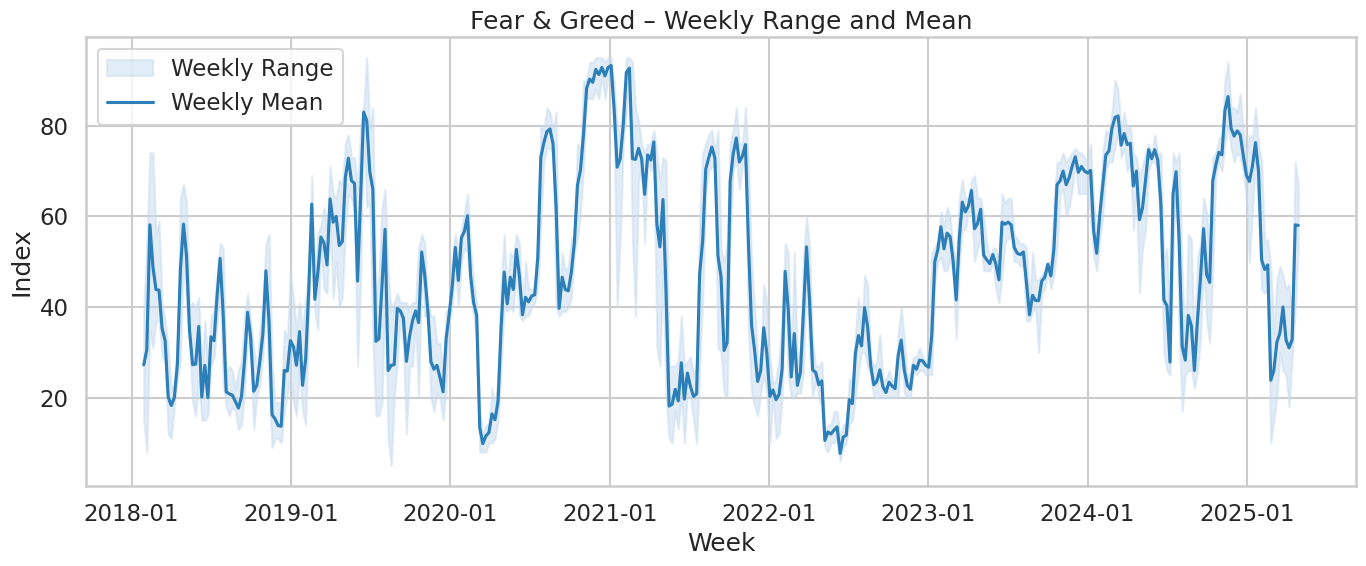

Saved cleaned_sentiment_daily.csv etc.


In [25]:
# 3. Visualizations
sns.set(style="whitegrid", context="talk")

# 3.1 Daily with 30D Mean
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(fg["date"], fg["sentiment_value"], label="Daily", color="#1f77b4", alpha=0.6)
ax.plot(fg["date"], fg["roll_30d_mean"], label="30D Mean", color="#d62728", linewidth=2)
ax.set_title("Bitcoin Fear & Greed Index – Daily with 30D Mean")
ax.set_xlabel("Date")
ax.set_ylabel("Index (0-100)")
ax.legend()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()

# 3.2 Regime distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=regime_counts, x="sentiment_class", y="count", ax=ax, palette="viridis")
ax.set_title("Sentiment Regime Counts")
ax.set_xlabel("Regime")
ax.set_ylabel("Days")
for c in ax.containers:
    ax.bar_label(c, fmt="%d")
plt.tight_layout()
plt.show()

# 3.3 Weekly summary (range)
fig, ax = plt.subplots(figsize=(14,6))
ax.fill_between(fg_weekly["week"], fg_weekly["min"], fg_weekly["max"], color="#c6dbef", alpha=0.5, label="Weekly Range")
ax.plot(fg_weekly["week"], fg_weekly["mean"], color="#2c7fb8", label="Weekly Mean")
ax.set_title("Fear & Greed – Weekly Range and Mean")
ax.set_xlabel("Week")
ax.set_ylabel("Index")
ax.legend()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()

# Save intermediate CSVs
fg.to_csv("cleaned_sentiment_daily.csv", index=False)
fg_weekly.to_csv("sentiment_weekly_summary.csv", index=False)
regime_counts.to_csv("sentiment_regime_counts.csv", index=False)
print("Saved cleaned_sentiment_daily.csv etc.")


In [26]:
#Now we use Place 'historical_data.csv' and 'cleaned_sentiment_daily.csv'
# 1. Load Large CSV
# Dtype helpers
DTYPE_MAP = {
    "Account": "category",
    "Coin": "category",
    "Execution Price": "float64",
    "Size Tokens": "float64",
    "Size USD": "float64",
    "Side": "category",
    "Timestamp IST": "string",
    "Start Position": "float64",
    "Direction": "category",
    "Closed PnL": "float64",
    "Transaction Hash": "string",
    "Order ID": "string",
    "Crossed": "string",
    "Fee": "float64",
    "Trade ID": "string",
    "Timestamp": "string",
}

# Standardization: lower + underscores for downstream
COL_RENAME = {
    "Account": "account",
    "Coin": "symbol",
    "Execution Price": "execution_price",
    "Size Tokens": "size_tokens",
    "Size USD": "size_usd",
    "Side": "side",
    "Timestamp IST": "timestamp_ist",
    "Start Position": "start_position",
    "Direction": "event",
    "Closed PnL": "closed_pnl",
    "Transaction Hash": "tx_hash",
    "Order ID": "order_id",
    "Crossed": "crossed",
    "Fee": "fee",
    "Trade ID": "trade_id",
    "Timestamp": "timestamp",
}

def process_chunk(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns=COL_RENAME)
    for c in ["execution_price","size_tokens","size_usd","start_position","closed_pnl","fee"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in ["account","symbol","side","event","crossed"]:
        if c in df.columns:
            df[c] = df[c].astype("string").str.strip()
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
        mask_epoch = (df["timestamp"].notna()) & (df["timestamp"] < 2e10)
        df["time"] = pd.NaT
        if mask_epoch.any():
            df.loc[mask_epoch, "time"] = pd.to_datetime(df.loc[mask_epoch, "timestamp"], unit="s", errors="coerce", utc=True)
        if "timestamp_ist" in df.columns:
            remain = df["time"].isna() & df["timestamp_ist"].notna()
            if remain.any():
                t_ist = pd.to_datetime(df.loc[remain, "timestamp_ist"], format="%d-%m-%Y %H:%M", errors="coerce")
                t_ist = t_ist.dt.tz_localize("Asia/Kolkata", nonexistent="NaT", ambiguous="NaT").dt.tz_convert("UTC")
                df.loc[remain, "time"] = t_ist
    else:
        if "timestamp_ist" in df.columns:
            t_ist = pd.to_datetime(df["timestamp_ist"], format="%d-%m-%Y %H:%M", errors="coerce")
            df["time"] = t_ist.dt.tz_localize("Asia/Kolkata", nonexistent="NaT", ambiguous="NaT").dt.tz_convert("UTC")
        else:
            df["time"] = pd.NaT

    if {"execution_price","size_tokens"}.issubset(df.columns):
        df["trade_value"] = df["execution_price"] * df["size_tokens"]
    else:
        df["trade_value"] = df.get("size_usd", np.nan)

    if "fee" in df.columns:
        df["fee_rate"] = df["fee"] / df["trade_value"].replace(0, np.nan)

    df["side_norm"] = df.get("side", pd.Series(index=df.index, dtype="string")).str.upper()
    df["event_norm"] = df.get("event", pd.Series(index=df.index, dtype="string")).str.upper()
    df["is_win"] = np.where(df.get("closed_pnl", 0) > 0, 1, np.where(df.get("closed_pnl", 0) < 0, 0, np.nan))
    df["date"] = pd.to_datetime(df["time"], errors="coerce").dt.tz_convert("UTC").dt.date
    return df

chunks = []
for chunk in pd.read_csv("historical_data.csv", dtype=DTYPE_MAP, chunksize=200000, low_memory=False):
    chunks.append(process_chunk(chunk))

df = pd.concat(chunks, ignore_index=True)
print("Rows loaded:", len(df))

keep_cols = [
    "account","symbol","execution_price","size_tokens","size_usd","side","event",
    "start_position","closed_pnl","fee","fee_rate","trade_value","time","date","is_win"
]
keep_cols = [c for c in keep_cols if c in df.columns]
df = df[keep_cols]
df.to_csv("cleaned_trades.csv", index=False)
print("Saved: cleaned_trades.csv")

/tmp/ipython-input-4073047125.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<DatetimeArray>
['2024-12-02 17:20:00+00:00', '2024-12-02 17:20:00+00:00',
 '2024-12-02 17:20:00+00:00', '2024-12-02 17:20:00+00:00',
 '2024-12-02 17:20:00+00:00', '2024-12-02 17:20:00+00:00',
 '2024-12-02 17:20:00+00:00', '2024-12-02 17:20:00+00:00',
 '2024-12-02 17:20:00+00:00', '2024-12-02 17:20:00+00:00',
 ...
 '2024-12-11 12:11:00+00:00', '2024-12-11 17:39:00+00:00',
 '2024-12-11 17:41:00+00:00', '2024-12-11 17:42:00+00:00',
 '2024-12-11 17:42:00+00:00', '2024-12-11 17:42:00+00:00',
 '2024-12-11 17:42:00+00:00', '2024-12-11 17:42:00+00:00',
 '2024-12-11 17:42:00+00:00', '2024-12-11 17:42:00+00:00']
Length: 121129, dtype: datetime64[ns, UTC]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[remain, "time"] = t_ist


Rows loaded: 121129
Saved: cleaned_trades.csv


In [27]:
# 2. Aggregate KPIs by date and symbol
def safe_sum(x):
    return np.nansum(x.values if hasattr(x, 'values') else x)

if "is_win" not in df.columns:
    cp = pd.to_numeric(df.get("closed_pnl"), errors="coerce")
    df["is_win"] = np.where(cp > 0, 1, np.where(cp < 0, 0, np.nan))

agg = df.copy()
agg["abs_pnl"] = np.abs(agg.get("closed_pnl", np.nan))
g_date = agg.groupby("date", dropna=False)
g_sym_date = agg.groupby(["date","symbol"], dropna=False)

by_date = g_date.agg(
    win_rate=("is_win", lambda s: np.nan if s.isna().all() else float(np.nanmean(s))*100.0),
    pnl_sum=("closed_pnl", safe_sum),
    pnl_mean=("closed_pnl", np.nanmean),
    volume_tokens=("size_tokens", safe_sum) if "size_tokens" in agg.columns else ("size_usd", safe_sum),
    fees_sum=("fee", safe_sum),
    trade_value_sum=("trade_value", safe_sum),
).reset_index()

trades_by_date = g_date.size().rename("trades").reset_index()
by_date = by_date.merge(trades_by_date, on="date", how="left")

if "trade_value_sum" in by_date.columns:
    by_date["avg_fee_rate"] = by_date["fees_sum"] / by_date["trade_value_sum"].replace(0, np.nan)
else:
    by_date["avg_fee_rate"] = np.nan

by_symbol_date = g_sym_date.agg(
    win_rate=("is_win", lambda s: np.nan if s.isna().all() else float(np.nanmean(s))*100.0),
    pnl_sum=("closed_pnl", safe_sum),
    pnl_mean=("closed_pnl", np.nanmean),
    volume_tokens=("size_tokens", safe_sum) if "size_tokens" in agg.columns else ("size_usd", safe_sum),
    fees_sum=("fee", safe_sum),
    trade_value_sum=("trade_value", safe_sum),
).reset_index()
trades_by_sym_date = g_sym_date.size().rename("trades").reset_index()
by_symbol_date = by_symbol_date.merge(trades_by_sym_date, on=["date","symbol"], how="left")

by_date.to_csv("kpi_by_date.csv", index=False)
by_symbol_date.to_csv("kpi_by_symbol_date.csv", index=False)


/tmp/ipython-input-95915347.py:14: FutureWarning: The provided callable <function nanmean at 0x7ae5cdfd3a60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_date = g_date.agg(
/tmp/ipython-input-95915347.py:31: FutureWarning: The provided callable <function nanmean at 0x7ae5cdfd3a60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_symbol_date = g_sym_date.agg(


In [28]:
# 3. Join with Sentiment
sent = pd.read_csv("cleaned_sentiment_daily.csv")
sent["date"] = pd.to_datetime(sent["date"]).dt.date

joined = by_date.merge(sent[["date","sentiment_value","sentiment_class"]], how="left", on="date")
joined.to_csv("kpi_with_sentiment.csv", index=False)

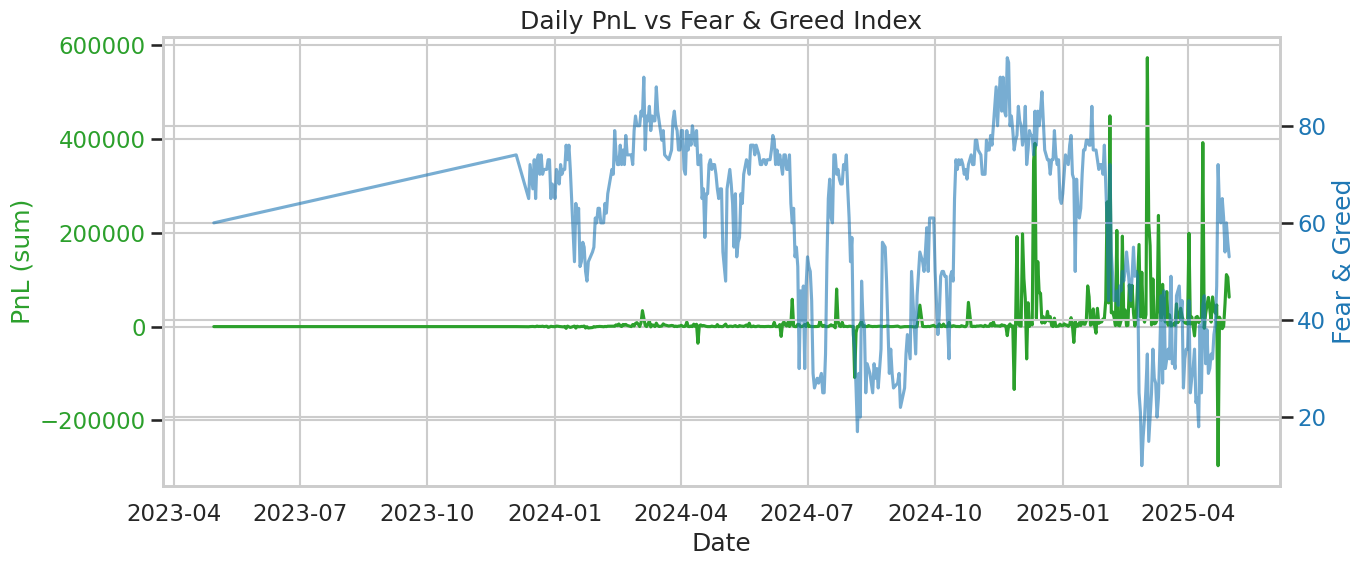

/tmp/ipython-input-94854792.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


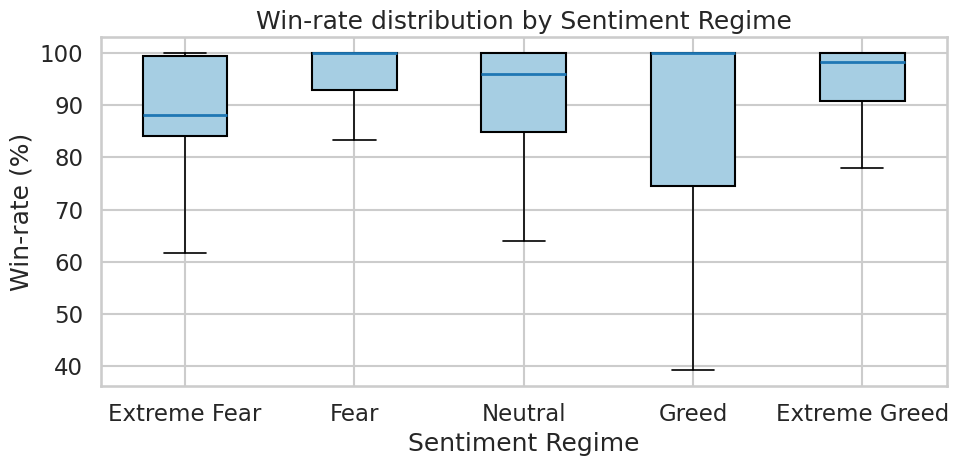

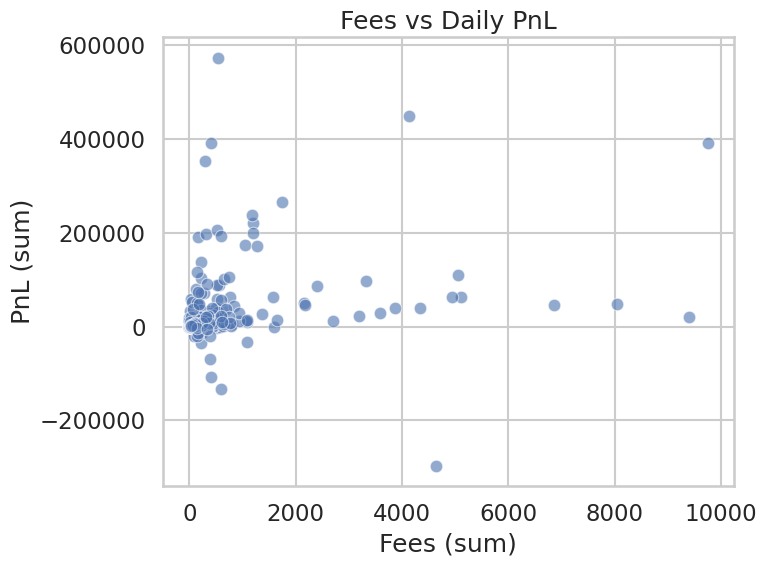

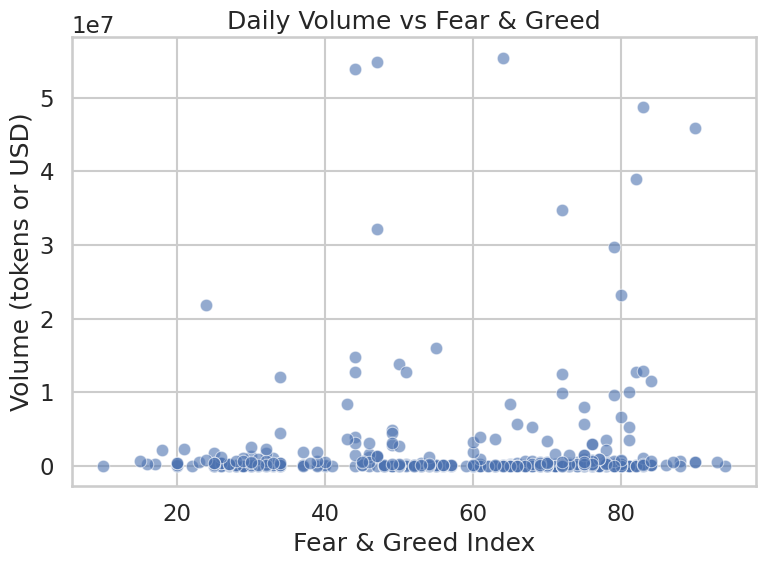

Saved aggregated CSVs and plots in current directory.


In [29]:
# 4. Visualizations
sns.set(style="whitegrid", context="talk")

# Plot 1: Daily PnL vs Fear & Greed Index
if "pnl_sum" in joined.columns and "sentiment_value" in joined.columns:
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(pd.to_datetime(joined["date"]), joined["pnl_sum"], color="#2ca02c", label="Daily PnL")
    ax1.set_ylabel("PnL (sum)", color="#2ca02c")
    ax1.tick_params(axis='y', labelcolor="#2ca02c")

    ax2 = ax1.twinx()
    ax2.plot(pd.to_datetime(joined["date"]), joined["sentiment_value"], color="#1f77b4", alpha=0.6, label="Sentiment")
    ax2.set_ylabel("Fear & Greed", color="#1f77b4")
    ax2.tick_params(axis='y', labelcolor="#1f77b4")

    ax1.set_title("Daily PnL vs Fear & Greed Index")
    ax1.set_xlabel("Date")
    ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    fig.tight_layout()
    plt.show()


# Plot 2: Win-rate distribution by Sentiment Regime
if "sentiment_class" in joined.columns and "win_rate" in joined.columns:
    order = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
    tmp = joined.copy()
    tmp["sentiment_class"] = pd.Categorical(tmp["sentiment_class"], categories=order, ordered=True)
    data = [tmp.loc[tmp["sentiment_class"] == cat, "win_rate"].dropna().values for cat in order]
    labels = [cat for cat, arr in zip(order, data) if len(arr) > 0]
    data = [arr for arr in data if len(arr) > 0]

    if len(data) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))
        bp = ax.boxplot(
            data,
            labels=labels,
            showfliers=False,
            patch_artist=True,
            medianprops=dict(color="#1f77b4", linewidth=2),
            boxprops=dict(linewidth=1.5, facecolor="#a6cee3"),
            whiskerprops=dict(linewidth=1.2),
            capprops=dict(linewidth=1.2),
        )
        ax.set_title("Win-rate distribution by Sentiment Regime")
        ax.set_xlabel("Sentiment Regime")
        ax.set_ylabel("Win-rate (%)")
        plt.tight_layout()
        plt.show()


# Plot 3: Fees vs Daily PnL
if {"fees_sum", "pnl_sum"}.issubset(joined.columns):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=joined, x="fees_sum", y="pnl_sum", ax=ax, alpha=0.6)
    ax.set_title("Fees vs Daily PnL")
    ax.set_xlabel("Fees (sum)")
    ax.set_ylabel("PnL (sum)")
    plt.tight_layout()
    plt.show()


# Plot 4: Daily Volume vs Fear & Greed
if {"volume_tokens", "sentiment_value"}.issubset(joined.columns):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=joined, x="sentiment_value", y="volume_tokens", ax=ax, alpha=0.6)
    ax.set_title("Daily Volume vs Fear & Greed")
    ax.set_xlabel("Fear & Greed Index")
    ax.set_ylabel("Volume (tokens or USD)")
    plt.tight_layout()
    plt.show()

print("Saved aggregated CSVs and plots in current directory.")